# Load data

In [1]:
import xarray as xr
import numpy as np

data_dir = 'D:/VScode/Last_deglaciation/data'
ds_sat_EOFs_MC = xr.open_dataset(data_dir + '/ds_sat_EOFs_MC.nc')
weight = np.cos(np.deg2rad(ds_sat_EOFs_MC['lat']))
weight = xr.where(weight < 0, 0, weight)

ds_sat_EOFs_MC['weight']=weight
ds_sat_EOFs_MC.info

<bound method Dataset.info of <xarray.Dataset>
Dimensions:                (age: 65, lat: 96, lon: 144)
Coordinates:
  * lat                    (lat) float32 -90.0 -88.11 -86.21 ... 88.11 90.0
  * lon                    (lon) float32 0.0 2.5 5.0 7.5 ... 352.5 355.0 357.5
  * age                    (age) float32 1.11e+04 1.13e+04 ... 2.37e+04 2.39e+04
Data variables:
    sat                    (age, lat, lon) float32 ...
    sat_std                (age, lat, lon) float32 ...
    sat_centered           (age, lat, lon) float32 ...
    sat_centered_weighted  (age, lat, lon) float32 ...
    EOF1                   (lat, lon) float32 ...
    EOF2                   (lat, lon) float32 ...
    class_label            (lat, lon) int64 ...
    weight                 (lat) float32 0.0 0.03306 0.06609 ... 0.03306 0.0>

# Calculate the weighted average curve

In [240]:
import xarray as xr

def cal_weighted_average_curve(ds, class_label):
    
    ds_sat_subset = ds.where(ds['class_label'] == class_label, drop=True)


    weights_broadcasted = ds_sat_subset['weight'].broadcast_like(ds_sat_subset['sat'])
    sum_weighted_sat = (ds_sat_subset['sat'] * weights_broadcasted).sum(dim=['lat', 'lon'])
    sum_weight_sat = weights_broadcasted.sum(dim=['lat', 'lon'])

    weighted_avg_sat = sum_weighted_sat / sum_weight_sat

    return weighted_avg_sat



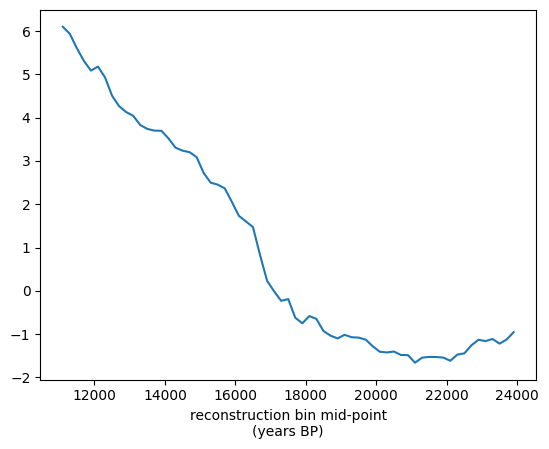

In [251]:
# Calculate the weighted average curve for class 0 and plot it
weighted_avg_sat = cal_weighted_average_curve(ds_sat_EOFs_MC, class_label=0)
weighted_avg_sat.plot(label='class 0')

In [206]:
import numpy as np
import Rbeast as rb

def find_cp(data, age,method='b',interval_L_indx=10, n_order_left=2,plot=False):
    # data = ds_sat_EOFs['sat'].isel(lat=lat, lon=lon)
    
    # # Plot the sample
    # data.plot()
    # data = data.values
    if method=='b':
        # cut the data according to interval_L_indx
        data=data[interval_L_indx:]
        age=age[interval_L_indx:]
    


        # flip the data
        data = data[::-1]

        # start_age = ds_sat_EOFs['age'][-1].values
        start_age=age[-1]
        # print(start_age)

        o = rb.beast(data, start=0, season='none')
        if plot:
            rb.plot(o)

        cps = o.trend.cp
        cps = cps[~np.isnan(cps)]

        cpPr = o.trend.cpPr
        cpPr = cpPr[~np.isnan(cpPr)]

        slpSgnPosPr_list = [o.trend.slpSgnPosPr[int(cp)] for cp in cps]
        slpSgnZeroPr_list = [o.trend.slpSgnZeroPr[int(cp)] for cp in cps]
        slpSgnNegPr_list = 1 - (np.array(slpSgnPosPr_list) + np.array(slpSgnZeroPr_list))

        cp_age_list = [start_age - cp*200 for cp in cps]
        flag = 'None'

        # Checking the conditions for the change points
        selected_cp_index = None
        for i, (pos_pr, neg_pr) in enumerate(zip(slpSgnPosPr_list, slpSgnNegPr_list)):
            if pos_pr != 1 and neg_pr != 0:
                selected_cp_index = i
                flag = 'slope'
                break

        # If no change point satisfies the condition, get the change point with the largest age
        if selected_cp_index is None:
            selected_cp_index = np.argmax(cp_age_list)
            flag = 'maxage'

        selected_cp_age = cp_age_list[selected_cp_index]
        value_at_cp = data[int(cps[selected_cp_index])]
        print('flag:', flag)

    if method=='min':
        min_index = np.argmin(data)
        # print('min_index:',min_index)
        selected_cp_age = age[min_index]
        value_at_cp = data[min_index]

    return selected_cp_age,value_at_cp

In [256]:
import numpy as np
import Rbeast as rb

def prepare_plot_data(weighted_avg_sat, ds_sat_EOFs_MC):
    sample = weighted_avg_sat.values
    # flip the sample
    sample = sample[::-1]

    sat_start = ds_sat_EOFs_MC['age'][-1].values
    print(sat_start)

    o = rb.beast(sample, start=0, season='none')

    cpOccPr = o.trend.cpOccPr    
    # flip the cpOccPr
    cpOccPr = cpOccPr[::-1]
    
    slpSgnPosPr = 1 - o.trend.slpSgnPosPr
    slpSgnZeroPr = o.trend.slpSgnZeroPr
    # flip the slpSgnPosPr
    slpSgnPosPr = slpSgnPosPr[::-1]
    slpSgnZeroPr = slpSgnZeroPr[::-1]

    cp_age, cp_sat = find_cp(weighted_avg_sat.values, ds_sat_EOFs_MC['age'].values, method='b', plot=False)

    return sample,cpOccPr, slpSgnPosPr, slpSgnZeroPr, cp_age





# Loop through all labels

In [264]:
# Loop through labels and call the functions
labels = [0, 1, 2, 3]
results = {}

for label in labels:
    weighted_avg_sat = cal_weighted_average_curve(ds_sat_EOFs_MC,label)
    results[label] = prepare_plot_data(weighted_avg_sat, ds_sat_EOFs_MC)

23900.0

INFO: To supress printing the parameers in beast123(),   set extra.printOptions = 0  
INFO: To supress printing the parameers in beast(),      set print.options = 0 
INFO: To supress printing the parameers in beast.irreg(),set print.options = 0 
INFO: To supress warning messages in beast123(),         set extra.quiet = 1  
INFO: To supress warning messages in beast(),            set quiet = 1 
INFO: To supress warning messages in beast.irreg(),      set quiet = 1 

#--------------------------------------------------#
#       Brief summary of Input Data                #
#--------------------------------------------------#
Data Dimension: One signal of length 65
IsOrdered     : Yes, ordered in time
IsRegular     : Yes, evenly spaced at interval of  1 (unknown unit)
hasSeasonCmpnt: False | no periodic or seasonal component. The model Y=Trend+Error is fitted.
HasOutlierCmpt: False | If true, Y=Trend+Outlier+Error (experimental) is fitted instead of Y=Trend+Error 
Detrend       : F

In [465]:
import matplotlib.pyplot as plt

def plot_average_curve(data,dpi,curve_color,left_width,right_width,floating_plot_left,floating_plot_bottom,floating_yaxis_side,show_xlabel=False):
    sample = data[0]
    cpOccPr = data[1]
    slpSgnPosPr = data[2]
    slpSgnZeroPr = data[3]
    cp_age = data[4]

    # Create the main figure and axes
    fig = plt.figure(figsize=(6, 4),dpi=dpi)
    gs = fig.add_gridspec(2, 1, height_ratios=[2, 0.5], hspace=0)

    # Plot weighted_avg_sat
    ax0 = fig.add_subplot(gs[0, 0])
    ax0.plot(ds_sat_EOFs_MC['age'].values, sample[::-1], label='weighted_avg_sat', color=curve_color,marker='o',markersize=5,markerfacecolor='white',markeredgewidth=1.5,linewidth=2)
    ax0.xaxis.set_visible(False)
    ax0.spines['bottom'].set_visible(False)
    ax0.set_xlim([np.min(ds_sat_EOFs_MC['age'].values), np.max(ds_sat_EOFs_MC['age'].values)])
    # ax0.set_ylim([-2, 6.5])
    ylim_min, ylim_max = ax0.get_ylim()
    ax0.plot([cp_age, cp_age], [ylim_min, ylim_max], color='black', linewidth=2)
    # set ylim
    ax0.set_ylim([ylim_min,ylim_max])
    # add xlabel
    ax0.set_xlabel('Age (ka)')
    # add ylabel
    ax0.set_ylabel('SAT (°C)')
    for axis in ['top','left','right']:
        ax0.spines[axis].set_linewidth(2)
    # ax0.grid(True)











    # Add a floating plot over ax0
    # t_cutoff_left=20000
    # t_cutoff_right=22500
    t_cutoff_left=cp_age-left_width
    t_cutoff_right=cp_age+right_width

    age_subset=ds_sat_EOFs_MC['age'].values[(ds_sat_EOFs_MC['age'].values>t_cutoff_left) & (ds_sat_EOFs_MC['age'].values<t_cutoff_right)]
    cpOccPr_subset=cpOccPr[(ds_sat_EOFs_MC['age'].values>t_cutoff_left) & (ds_sat_EOFs_MC['age'].values<t_cutoff_right)]

    # left, width = 0.647, .2
    # bottom, height = .66, .2
    fraction=(t_cutoff_right-t_cutoff_left)/(ax0.get_xlim()[1] - ax0.get_xlim()[0])
    left, width = floating_plot_left, .2
    bottom, height = floating_plot_bottom, .25
    floating_ax = fig.add_axes([left, bottom, width, height])
    floating_ax.plot(age_subset, cpOccPr_subset, color='gray')
    floating_ax.fill_between(age_subset, 0, cpOccPr_subset, facecolor='gray', alpha=0.3)
    # get ylim
    ylim_min, ylim_max = floating_ax.get_ylim()
    ylim_max = np.round(ylim_max,1)
    floating_ax.set_yticks([0, ylim_max])
    floating_ax.set_ylim([ylim_min,ylim_max])
    floating_ax.plot([cp_age, cp_age], [ylim_min,ylim_max], color='black', linewidth=2)

    floating_ax.invert_yaxis()  # Invert the y-axis
    floating_ax.set_xlim([t_cutoff_left, t_cutoff_right])
    floating_ax.spines['right'].set_visible(False)
    # floating_ax.spines['left'].set_visible(False)
    floating_ax.spines['bottom'].set_visible(False)
    floating_ax.spines['top'].set_visible(False)
    floating_ax.spines['left'].set_linewidth(1.5)
    if floating_yaxis_side=='right':
        floating_ax.yaxis.tick_right()
        floating_ax.spines['right'].set_visible(True)
        floating_ax.spines['left'].set_visible(False)
        floating_ax.spines['right'].set_linewidth(1.5)

        
    # floating_ax.yaxis.set_visible(False)
    # not show xtick labels 
    floating_ax.xaxis.set_visible(False)
    # not show ytick labels
    # floating_ax.yaxis.set_visible(False)
    # show xtick labels on the top side
    floating_ax.xaxis.tick_top()











    # Plot slpSgnPosPr
    ax1 = fig.add_subplot(gs[1, 0])
    # ax1.plot(ds_sat_EOFs_MC['age'].values, slpSgnPosPr, color='red', label='slpSgnPosPr',alpha=0.3)
    # ax1.plot(ds_sat_EOFs_MC['age'].values, slpSgnZeroPr, color='purple', label='slpSgnZeroPr',alpha=0.3)
    ax1.fill_between(ds_sat_EOFs_MC['age'].values, slpSgnPosPr, 0, facecolor='blue', alpha=0.4)
    ax1.fill_between(ds_sat_EOFs_MC['age'].values, slpSgnPosPr, 1, facecolor='red', alpha=0.4)
    # ax1.set_ylim([-0.1, 1.05])
    ylim_min, ylim_max = ax1.get_ylim()
    ax1.plot([cp_age, cp_age], [ylim_min,ylim_max], color='black', linewidth=2)
    # set ylim
    ax1.set_ylim([ylim_min,ylim_max])
    ax1.set_yticks([0, 1])
    ax1.yaxis.tick_right()
    ax1.spines['top'].set_visible(False)
    ax1.set_xlim([np.min(ds_sat_EOFs_MC['age'].values), np.max(ds_sat_EOFs_MC['age'].values)])

    for axis in ['bottom','left','right']:
        ax1.spines[axis].set_linewidth(2)
    # add xlabel
    if show_xlabel:
        ax1.set_xlabel('Age (ka)')
    # ax1.set_xlabel('Age (ka)')

    # Adjust the layout
    plt.show()


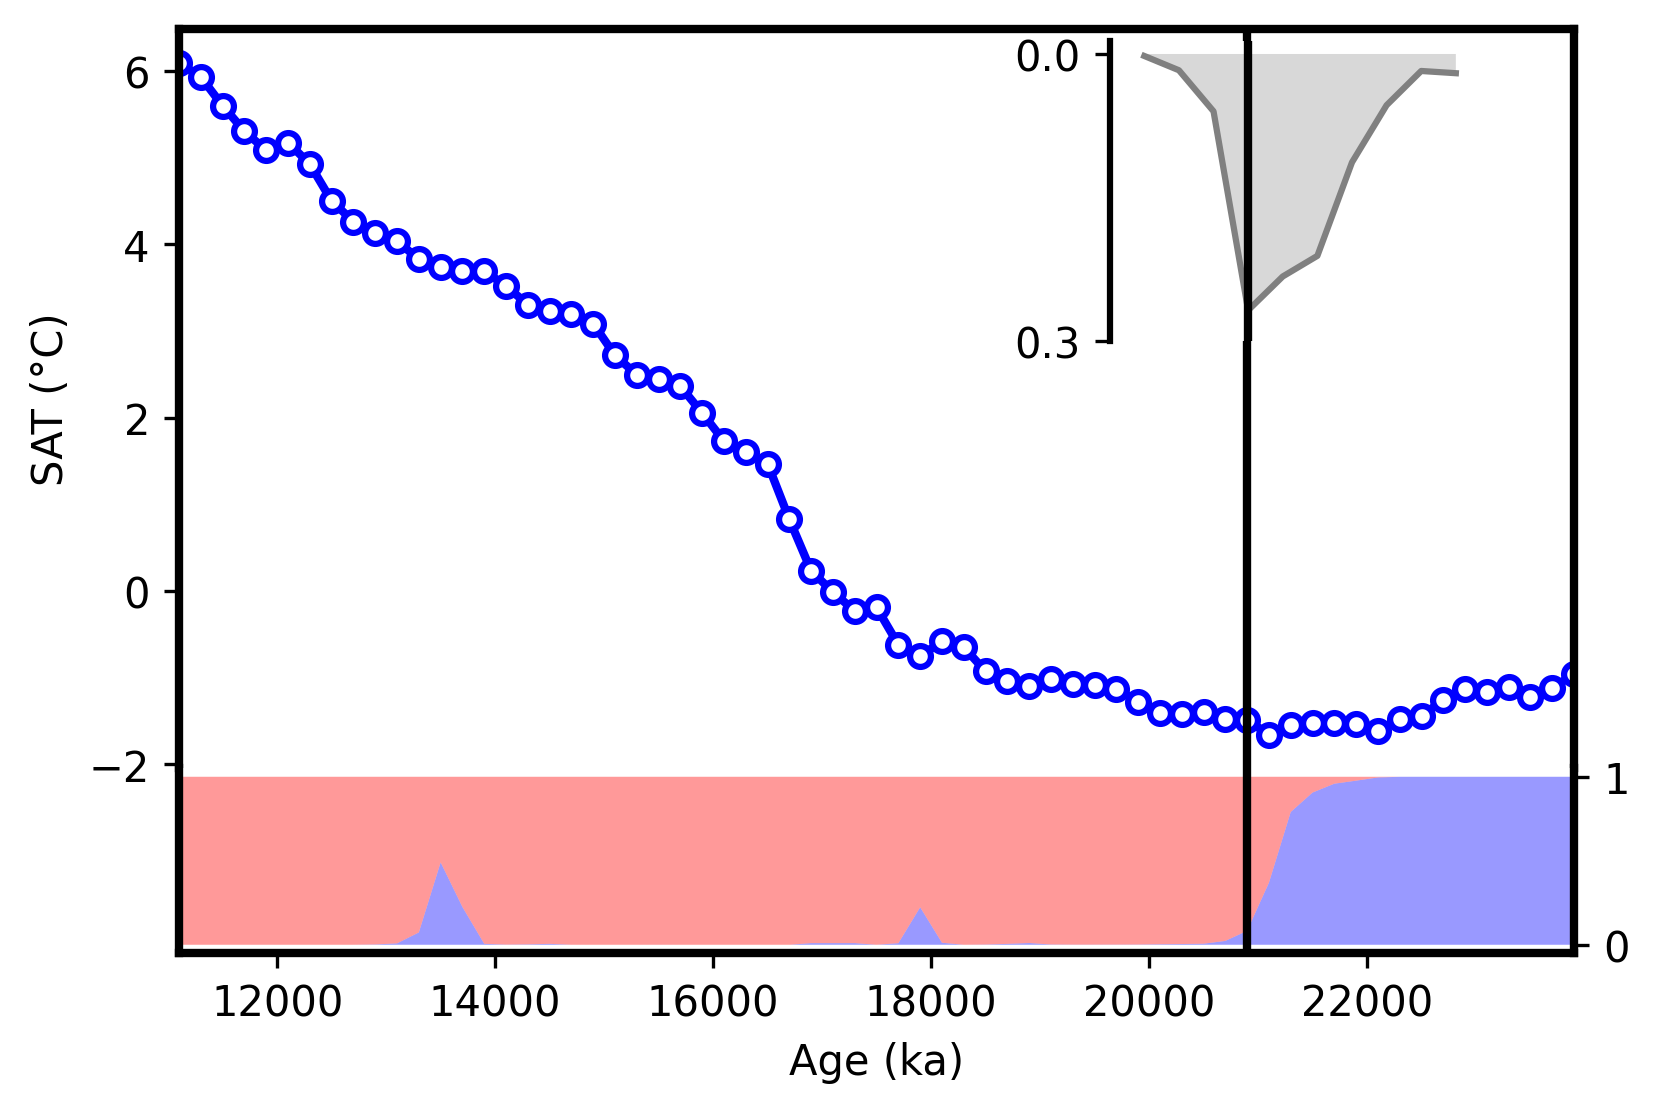

In [469]:
colors = ['blue', 'red', 'green', 'orange']
plot_average_curve(results[0],dpi=300,curve_color=colors[0],left_width=800,right_width=1280,floating_plot_left=0.642,floating_plot_bottom=0.62,floating_yaxis_side='left',show_xlabel=True)

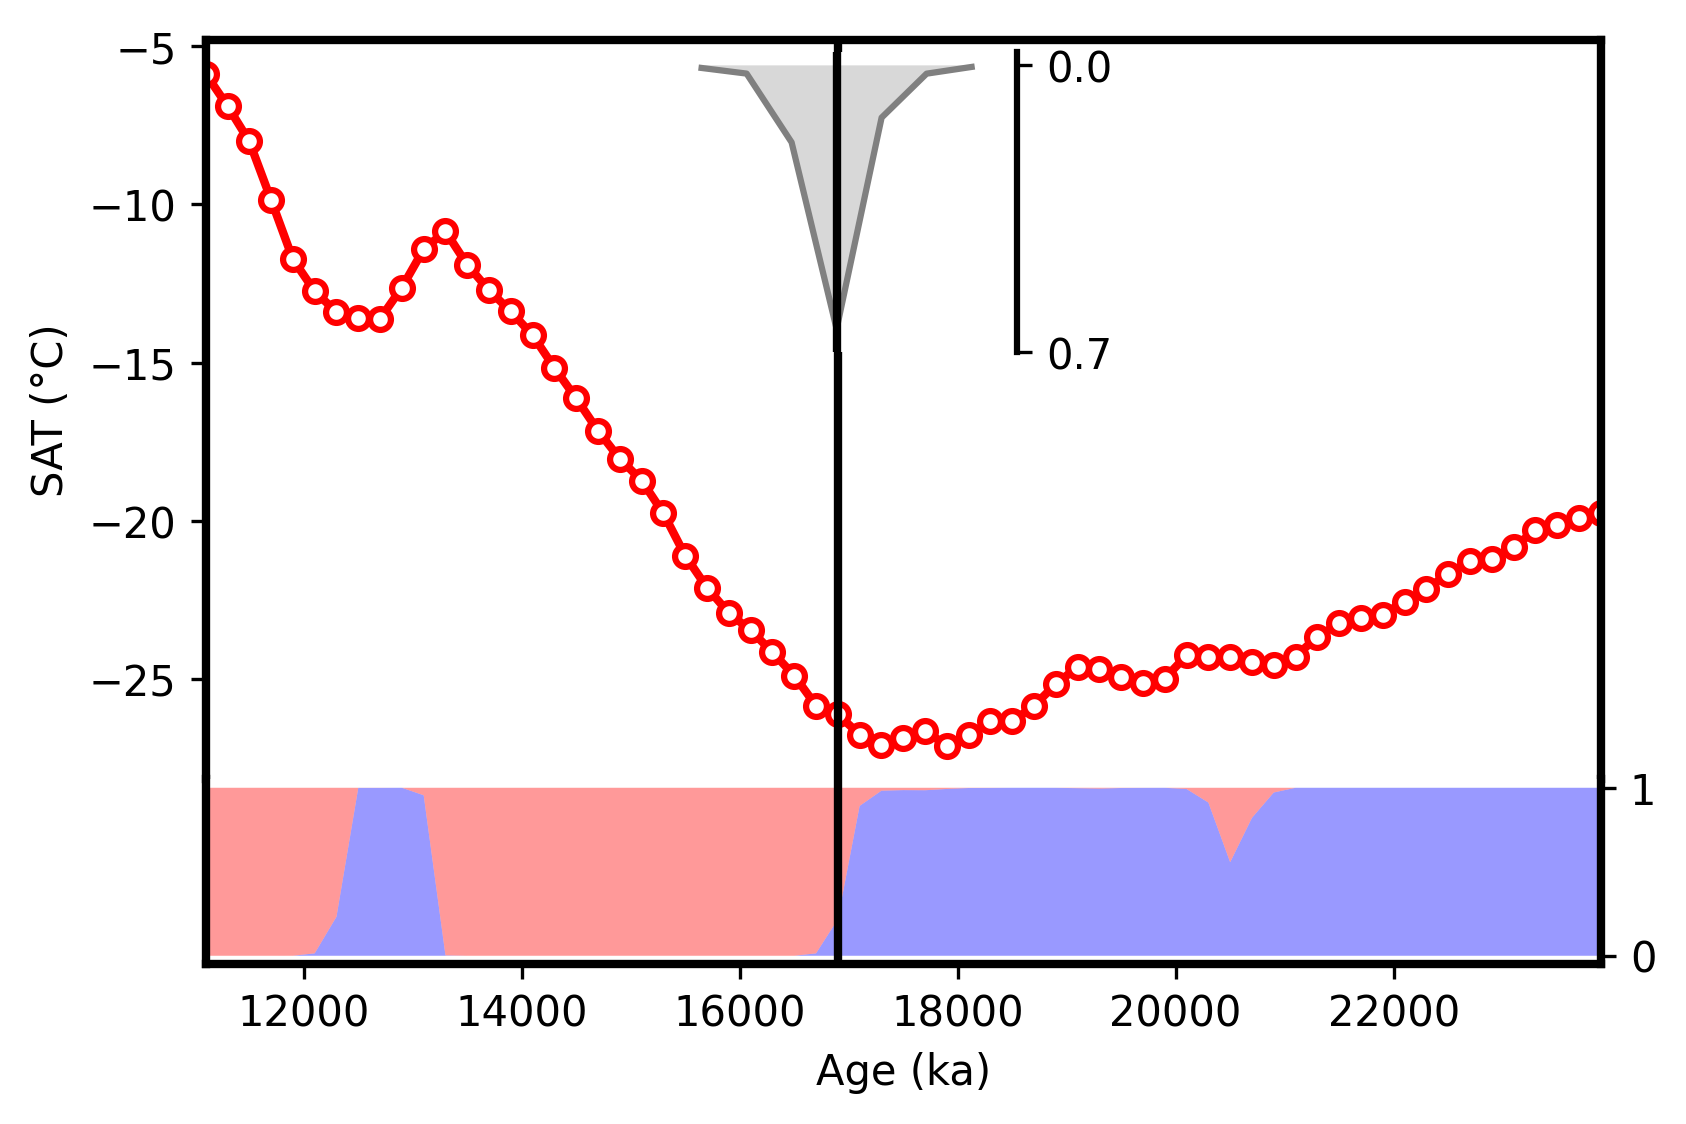

In [468]:
plot_average_curve(results[1],dpi=300,curve_color=colors[1],left_width=800,right_width=800,floating_plot_left=0.3755,floating_plot_bottom=0.62,floating_yaxis_side='right',show_xlabel=True)

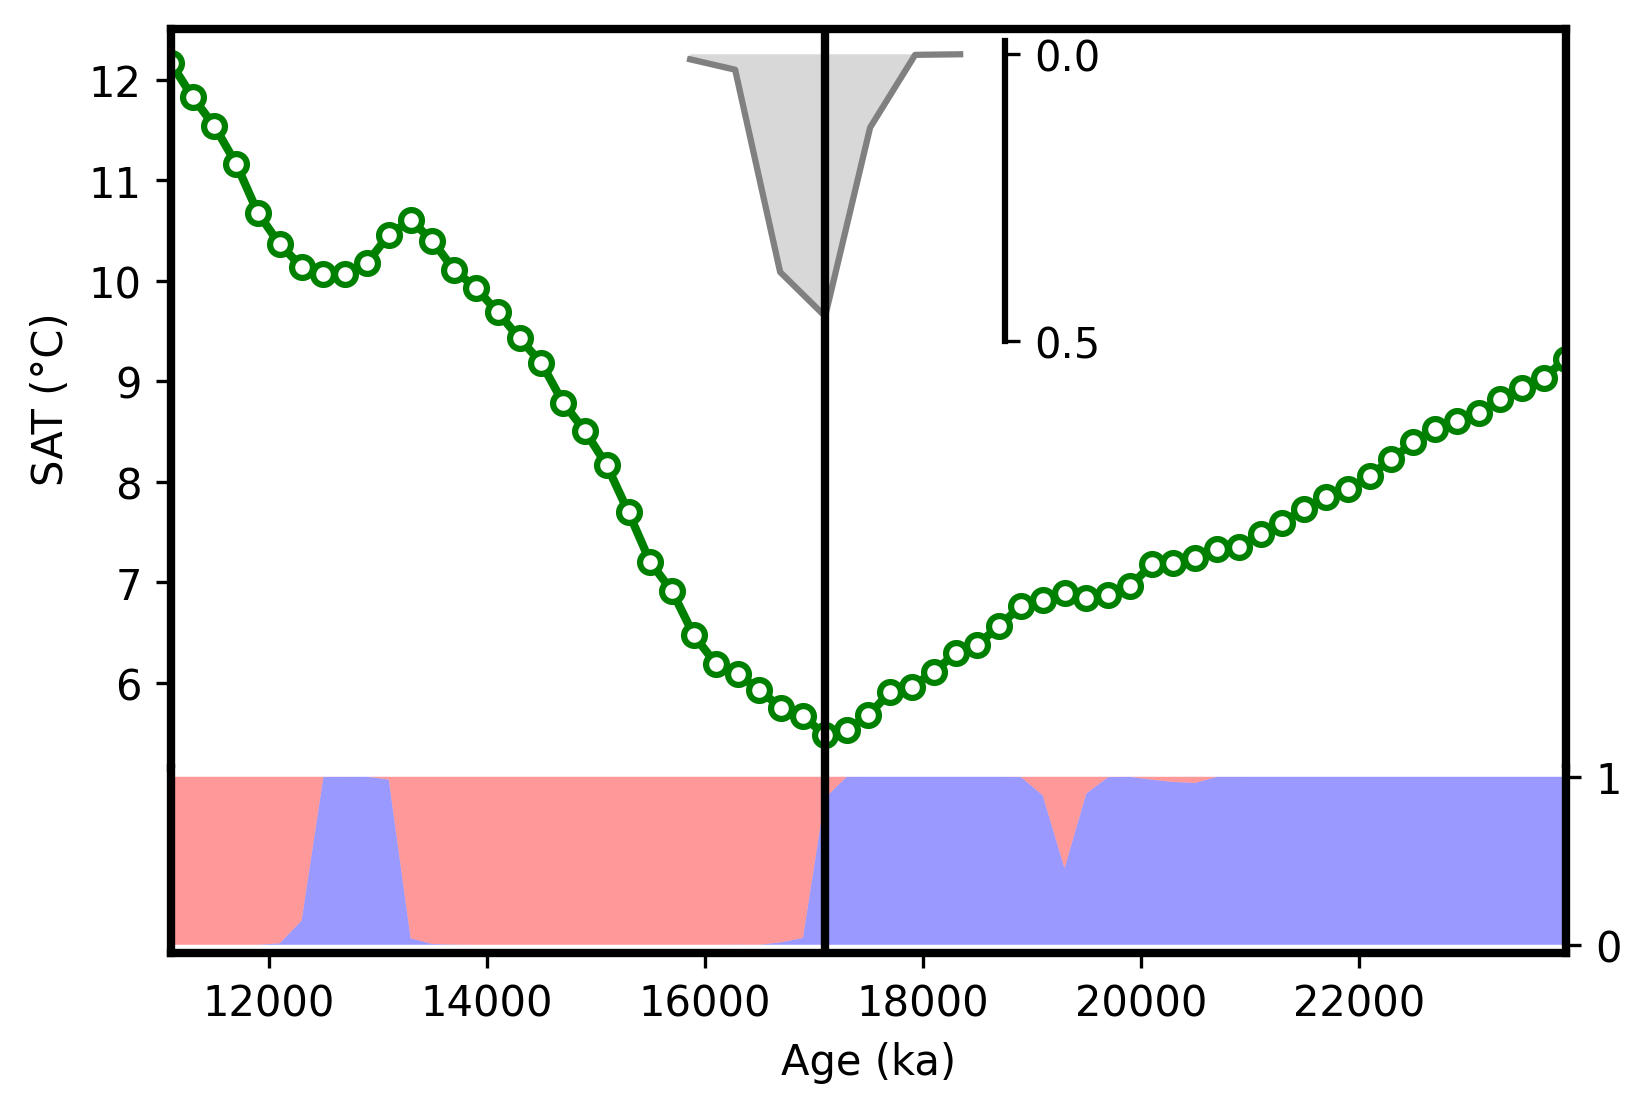

In [467]:
plot_average_curve(results[2],dpi=300,curve_color=colors[2],left_width=800,right_width=800,floating_plot_left=0.3885,floating_plot_bottom=0.62,floating_yaxis_side='right',show_xlabel=True)

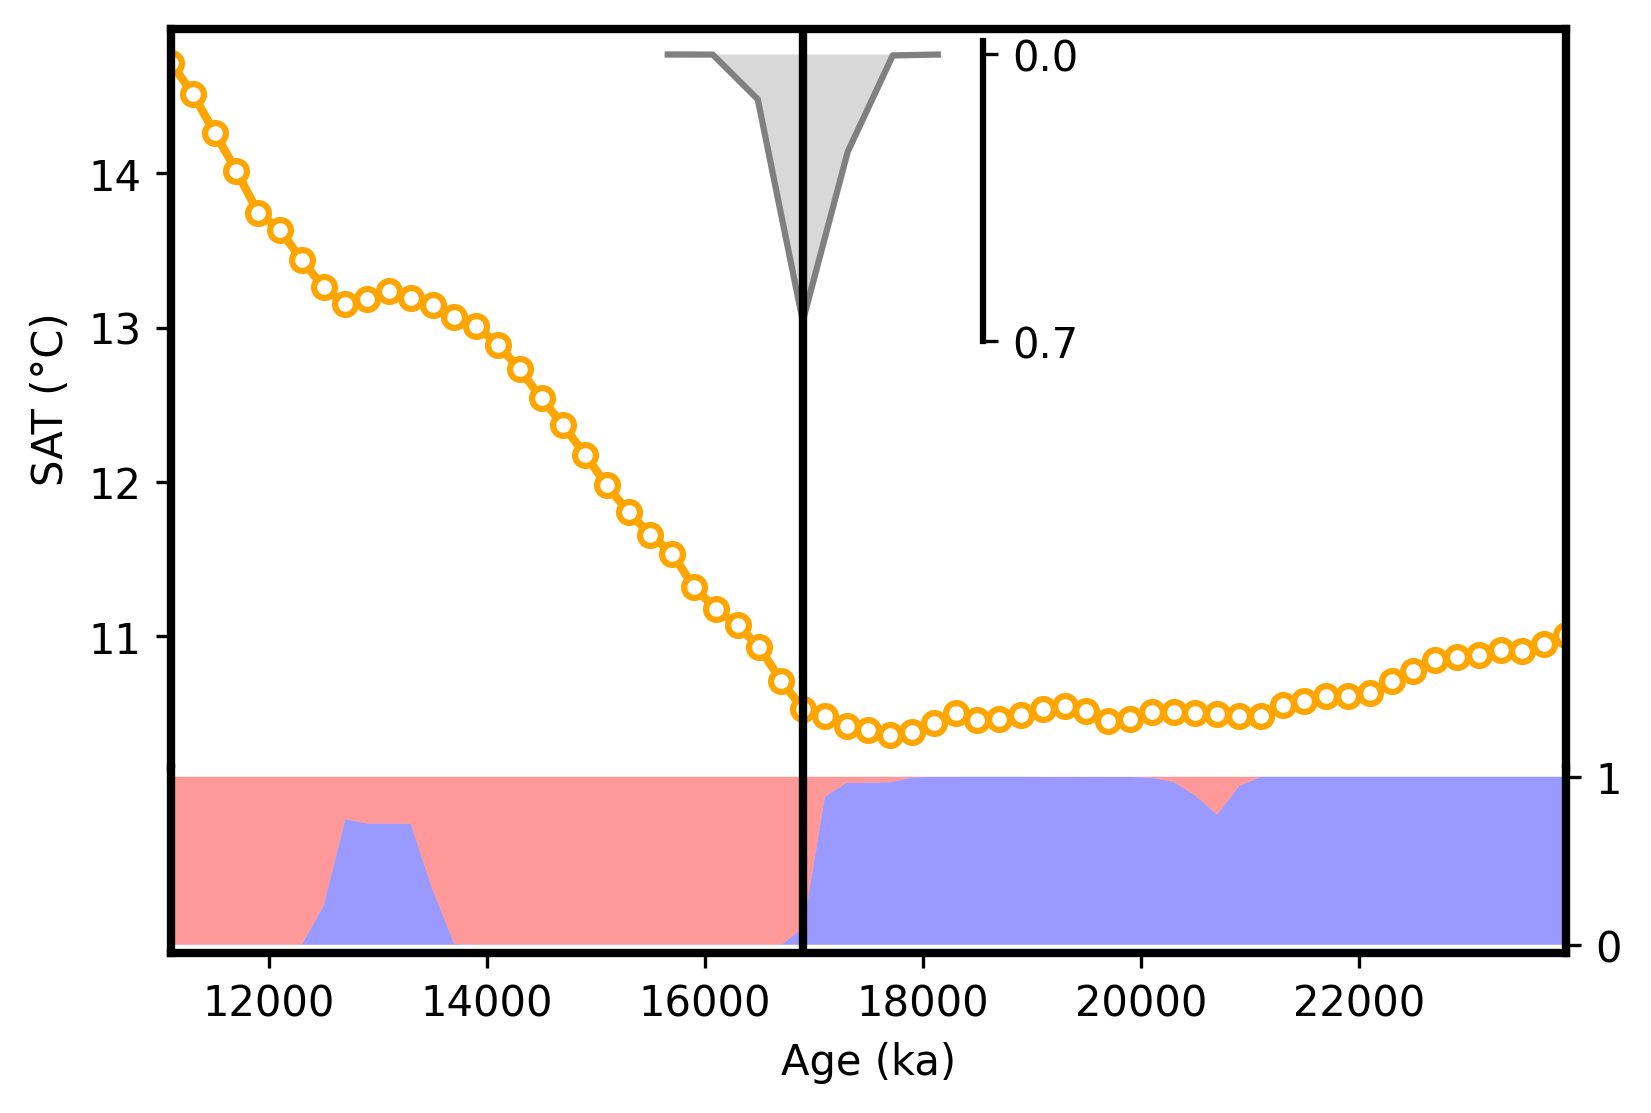

In [466]:
plot_average_curve(results[3],dpi=300,curve_color=colors[3],left_width=800,right_width=800,floating_plot_left=0.376,floating_plot_bottom=0.62,floating_yaxis_side='right',show_xlabel=True)

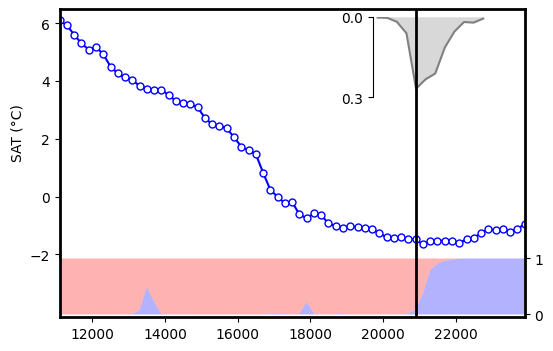

In [311]:
import matplotlib.pyplot as plt

sample = results[0][0]
cpOccPr = results[0][1]
slpSgnPosPr = results[0][2]
slpSgnZeroPr = results[0][3]
cp_age = results[0][4]

# Create the main figure and axes
fig = plt.figure(figsize=(6, 4))
gs = fig.add_gridspec(2, 1, height_ratios=[2, 0.5], hspace=0)

# Plot weighted_avg_sat
ax0 = fig.add_subplot(gs[0, 0])
ax0.plot(ds_sat_EOFs_MC['age'].values, sample[::-1], label='weighted_avg_sat', color='blue',marker='o',markersize=5,markerfacecolor='white')
ax0.xaxis.set_visible(False)
ax0.spines['bottom'].set_visible(False)
ax0.set_xlim([np.min(ds_sat_EOFs_MC['age'].values), np.max(ds_sat_EOFs_MC['age'].values)])
# ax0.set_ylim([-2, 6.5])
ylim_min, ylim_max = ax0.get_ylim()
ax0.plot([cp_age, cp_age], [ylim_min, ylim_max], color='black', linewidth=2)
# set ylim
ax0.set_ylim([ylim_min,ylim_max])
# add xlabel
ax0.set_xlabel('Age (ka)')
# add ylabel
ax0.set_ylabel('SAT (°C)')
for axis in ['top','left','right']:
    ax0.spines[axis].set_linewidth(2)


# Add a floating plot over ax0
t_cutoff_left=20000
t_cutoff_right=22500

age_subset=ds_sat_EOFs_MC['age'].values[(ds_sat_EOFs_MC['age'].values>t_cutoff_left) & (ds_sat_EOFs_MC['age'].values<t_cutoff_right)]
cpOccPr_subset=cpOccPr[(ds_sat_EOFs_MC['age'].values>t_cutoff_left) & (ds_sat_EOFs_MC['age'].values<t_cutoff_right)]

left, width = 0.647, .2
bottom, height = .66, .2
floating_ax = fig.add_axes([left, bottom, width, height])
floating_ax.plot(age_subset, cpOccPr_subset, color='gray')
floating_ax.fill_between(age_subset, 0, cpOccPr_subset, facecolor='gray', alpha=0.3)
floating_ax.plot([cp_age, cp_age], [-0.05, 0.3], color='black', linewidth=2)
floating_ax.set_yticks([0, 0.3])
floating_ax.set_ylim([0, 0.3])
floating_ax.invert_yaxis()  # Invert the y-axis
floating_ax.set_xlim([t_cutoff_left, t_cutoff_right])
floating_ax.spines['right'].set_visible(False)
# floating_ax.spines['left'].set_visible(False)
floating_ax.spines['bottom'].set_visible(False)
floating_ax.spines['top'].set_visible(False)
# floating_ax.yaxis.set_visible(False)
# not show xtick labels 
floating_ax.xaxis.set_visible(False)
# not show ytick labels
# floating_ax.yaxis.set_visible(False)
# show xtick labels on the top side
floating_ax.xaxis.tick_top()


# Plot slpSgnPosPr
ax1 = fig.add_subplot(gs[1, 0])
# ax1.plot(ds_sat_EOFs_MC['age'].values, slpSgnPosPr, color='red', label='slpSgnPosPr',alpha=0.3)
# ax1.plot(ds_sat_EOFs_MC['age'].values, slpSgnZeroPr, color='purple', label='slpSgnZeroPr',alpha=0.3)
ax1.fill_between(ds_sat_EOFs_MC['age'].values, slpSgnPosPr, 0, facecolor='blue', alpha=0.3)
ax1.fill_between(ds_sat_EOFs_MC['age'].values, slpSgnPosPr, 1, facecolor='red', alpha=0.3)
# ax1.set_ylim([-0.1, 1.05])
ylim_min, ylim_max = ax1.get_ylim()
ax1.plot([cp_age, cp_age], [ylim_min,ylim_max], color='black', linewidth=2)
# set ylim
ax1.set_ylim([ylim_min,ylim_max])
ax1.set_yticks([0, 1])
ax1.yaxis.tick_right()
ax1.spines['top'].set_visible(False)
ax1.set_xlim([np.min(ds_sat_EOFs_MC['age'].values), np.max(ds_sat_EOFs_MC['age'].values)])

for axis in ['bottom','left','right']:
    ax1.spines[axis].set_linewidth(2)
# add xlabel
# ax1.set_xlabel('Age (ka)')

# Adjust the layout
plt.show()


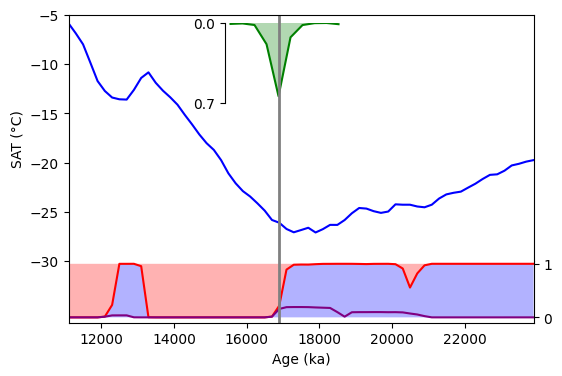

In [286]:
import matplotlib.pyplot as plt

sample = results[1][0]
cpOccPr = results[1][1]
slpSgnPosPr = results[1][2]
slpSgnZeroPr = results[1][3]
cp_age = results[1][4]

# Create the main figure and axes
fig = plt.figure(figsize=(6, 4))
gs = fig.add_gridspec(2, 1, height_ratios=[2, 0.5], hspace=0)

# Plot weighted_avg_sat
ax0 = fig.add_subplot(gs[0, 0])
ax0.plot(ds_sat_EOFs_MC['age'].values, sample[::-1], label='weighted_avg_sat', color='blue')
ax0.xaxis.set_visible(False)
ax0.spines['bottom'].set_visible(False)
ax0.set_xlim([np.min(ds_sat_EOFs_MC['age'].values), np.max(ds_sat_EOFs_MC['age'].values)])
ax0.set_ylim([-30, -5])
# plot a vertical line at cp_age from ylim min to ylim max
ax0.plot([cp_age, cp_age], [-30,-5], color='gray', linewidth=2)
# add xlabel
ax0.set_xlabel('Age (ka)')
# add ylabel
ax0.set_ylabel('SAT (°C)')

# Add a floating plot over ax0
t_cutoff_left=16000
t_cutoff_right=18000

age_subset=ds_sat_EOFs_MC['age'].values[(ds_sat_EOFs_MC['age'].values>t_cutoff_left) & (ds_sat_EOFs_MC['age'].values<t_cutoff_right)]
cpOccPr_subset=cpOccPr[(ds_sat_EOFs_MC['age'].values>t_cutoff_left) & (ds_sat_EOFs_MC['age'].values<t_cutoff_right)]

left, width = 0.385, .2
bottom, height = .66, .2
floating_ax = fig.add_axes([left, bottom, width, height])
floating_ax.plot(age_subset, cpOccPr_subset, color='green')
floating_ax.fill_between(age_subset, 0, cpOccPr_subset, facecolor='green', alpha=0.3)
ylim_min,ylim_max=ax0.get_ylim()
floating_ax.plot([cp_age, cp_age], [-0.05, 0.7], color='gray', linewidth=2)
floating_ax.set_yticks([0, 0.7])
floating_ax.set_ylim([0, 0.7])
floating_ax.invert_yaxis()  # Invert the y-axis
floating_ax.set_xlim([t_cutoff_left, t_cutoff_right])
floating_ax.spines['right'].set_visible(False)
# floating_ax.spines['left'].set_visible(False)
floating_ax.spines['bottom'].set_visible(False)
floating_ax.spines['top'].set_visible(False)
# floating_ax.yaxis.set_visible(False)
# not show xtick labels 
floating_ax.xaxis.set_visible(False)
# not show ytick labels
# floating_ax.yaxis.set_visible(False)
# show xtick labels on the top side
floating_ax.xaxis.tick_top()


# Plot slpSgnPosPr
ax1 = fig.add_subplot(gs[1, 0])
ax1.plot(ds_sat_EOFs_MC['age'].values, slpSgnPosPr, color='red', label='slpSgnPosPr')
ax1.plot(ds_sat_EOFs_MC['age'].values, slpSgnZeroPr, color='purple', label='slpSgnZeroPr')
ax1.fill_between(ds_sat_EOFs_MC['age'].values, slpSgnPosPr, 0, facecolor='blue', alpha=0.3)
ax1.fill_between(ds_sat_EOFs_MC['age'].values, slpSgnPosPr, 1, facecolor='red', alpha=0.3)
ax1.set_ylim([-0.1, 1.05])
ax1.plot([cp_age, cp_age], [-0.1, 1.05], color='gray', linewidth=2)
ax1.set_yticks([0, 1])
ax1.yaxis.tick_right()
ax1.spines['top'].set_visible(False)
ax1.set_xlim([np.min(ds_sat_EOFs_MC['age'].values), np.max(ds_sat_EOFs_MC['age'].values)])
# add xlabel
ax1.set_xlabel('Age (ka)')

# Adjust the layout
plt.show()


In [252]:


import numpy as np
import Rbeast as rb

sample=weighted_avg_sat.values
# flip the sample
sample=sample[::-1]

sat_start=ds_sat_EOFs_MC['age'][-1].values
print(sat_start)

o = rb.beast(sample, start=0,season='none')
cpOccPr=o.trend.cpOccPr    
# flip the cpOccPr
cpOccPr=cpOccPr[::-1]
# 
slpSgnPosPr=1-o.trend.slpSgnPosPr
slpSgnZeroPr=o.trend.slpSgnZeroPr
# flip the slpSgnPosPr
slpSgnPosPr=slpSgnPosPr[::-1]
slpSgnZeroPr=slpSgnZeroPr[::-1]

cp_age,cp_sat=find_cp(weighted_avg_sat.values,ds_sat_EOFs_MC['age'].values,method='b')

23900.0

INFO: To supress printing the parameers in beast123(),   set extra.printOptions = 0  
INFO: To supress printing the parameers in beast(),      set print.options = 0 
INFO: To supress printing the parameers in beast.irreg(),set print.options = 0 
INFO: To supress warning messages in beast123(),         set extra.quiet = 1  
INFO: To supress warning messages in beast(),            set quiet = 1 
INFO: To supress warning messages in beast.irreg(),      set quiet = 1 

#--------------------------------------------------#
#       Brief summary of Input Data                #
#--------------------------------------------------#
Data Dimension: One signal of length 65
IsOrdered     : Yes, ordered in time
IsRegular     : Yes, evenly spaced at interval of  1 (unknown unit)
hasSeasonCmpnt: False | no periodic or seasonal component. The model Y=Trend+Error is fitted.
HasOutlierCmpt: False | If true, Y=Trend+Outlier+Error (experimental) is fitted instead of Y=Trend+Error 
Detrend       : F

In [234]:
results[0][0].shape

(65,)

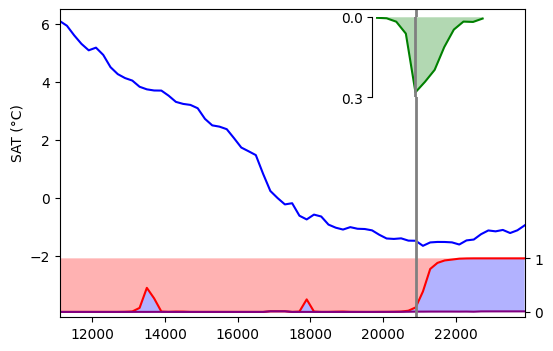

In [253]:
import matplotlib.pyplot as plt

# timeseries = results[0][0]
# cpOccPr = results[0][1]
# slpSgnPosPr = results[0][2]
# slpSgnZeroPr = results[0][3]
# cp_age = results[0][4]

# Create the main figure and axes
fig = plt.figure(figsize=(6, 4))
gs = fig.add_gridspec(2, 1, height_ratios=[2, 0.5], hspace=0)

# Plot weighted_avg_sat
ax0 = fig.add_subplot(gs[0, 0])
ax0.plot(ds_sat_EOFs_MC['age'].values, sample[::-1], label='weighted_avg_sat', color='blue')
ax0.xaxis.set_visible(False)
ax0.spines['bottom'].set_visible(False)
ax0.set_xlim([np.min(ds_sat_EOFs_MC['age'].values), np.max(ds_sat_EOFs_MC['age'].values)])
ax0.set_ylim([-2, 6.5])
ax0.plot([cp_age, cp_age], [-2, 6.5], color='gray', linewidth=2)
# add xlabel
ax0.set_xlabel('Age (ka)')
# add ylabel
ax0.set_ylabel('SAT (°C)')

# Add a floating plot over ax0
t_cutoff_left=20000
t_cutoff_right=22500

age_subset=ds_sat_EOFs_MC['age'].values[(ds_sat_EOFs_MC['age'].values>t_cutoff_left) & (ds_sat_EOFs_MC['age'].values<t_cutoff_right)]
cpOccPr_subset=cpOccPr[(ds_sat_EOFs_MC['age'].values>t_cutoff_left) & (ds_sat_EOFs_MC['age'].values<t_cutoff_right)]

left, width = 0.646, .2
bottom, height = .66, .2
floating_ax = fig.add_axes([left, bottom, width, height])
floating_ax.plot(age_subset, cpOccPr_subset, color='green')
floating_ax.fill_between(age_subset, 0, cpOccPr_subset, facecolor='green', alpha=0.3)
floating_ax.plot([cp_age, cp_age], [-0.05, 0.3], color='gray', linewidth=2)
floating_ax.set_yticks([0, 0.3])
floating_ax.set_ylim([0, 0.3])
floating_ax.invert_yaxis()  # Invert the y-axis
floating_ax.set_xlim([t_cutoff_left, t_cutoff_right])
floating_ax.spines['right'].set_visible(False)
# floating_ax.spines['left'].set_visible(False)
floating_ax.spines['bottom'].set_visible(False)
floating_ax.spines['top'].set_visible(False)
# floating_ax.yaxis.set_visible(False)
# not show xtick labels 
floating_ax.xaxis.set_visible(False)
# not show ytick labels
# floating_ax.yaxis.set_visible(False)
# show xtick labels on the top side
floating_ax.xaxis.tick_top()


# Plot slpSgnPosPr
ax1 = fig.add_subplot(gs[1, 0])
ax1.plot(ds_sat_EOFs_MC['age'].values, slpSgnPosPr, color='red', label='slpSgnPosPr')
ax1.plot(ds_sat_EOFs_MC['age'].values, slpSgnZeroPr, color='purple', label='slpSgnZeroPr')
ax1.fill_between(ds_sat_EOFs_MC['age'].values, slpSgnPosPr, 0, facecolor='blue', alpha=0.3)
ax1.fill_between(ds_sat_EOFs_MC['age'].values, slpSgnPosPr, 1, facecolor='red', alpha=0.3)
ax1.set_ylim([-0.1, 1.05])
ax1.plot([cp_age, cp_age], [-0.1, 1.05], color='gray', linewidth=2)
ax1.set_yticks([0, 1])
ax1.yaxis.tick_right()
ax1.spines['top'].set_visible(False)
ax1.set_xlim([np.min(ds_sat_EOFs_MC['age'].values), np.max(ds_sat_EOFs_MC['age'].values)])

# Adjust the layout
plt.show()


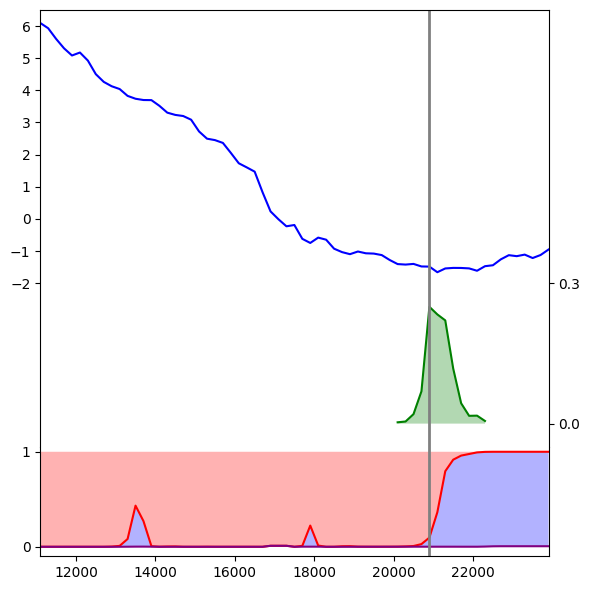

In [132]:
import matplotlib.pyplot as plt

# Create the main figure and axes
fig = plt.figure(figsize=(6, 6))
gs = fig.add_gridspec(3, 1,height_ratios=[2.5, 1.5,1],hspace=0)
#

# Plot weighted_avg_sat
ax0 = fig.add_subplot(gs[0, 0])
ax0.plot(ds_sat_EOFs_MC['age'].values, sample[::-1], label='weighted_avg_sat', color='blue')  # Flipping it back
# ax0.set_title('Weighted Average SAT')
# ax0.legend()
# not display the x-axis label
ax0.xaxis.set_visible(False)
# not display the bottom box
ax0.spines['bottom'].set_visible(False)
ax0.set_xlim([np.min(ds_sat_EOFs_MC['age'].values), np.max(ds_sat_EOFs_MC['age'].values)])
# set ylim
ax0.set_ylim([-2, 6.5])
# plot a vertical line at cp_age that go through all the plot
ax0.plot([cp_age, cp_age], [-2, 6.5], color='gray', linewidth=2)




# Plot cpOccPr
ax1 = fig.add_subplot(gs[1, 0])
# ax1.plot(ds_sat_EOFs_MC['age'].values, cpOccPr, label='cpOccPr', color='green')
# only plot data > tt_cutoff_left and < tt_cutoff_right
t_cutoff_left=20000
t_cutoff_right=22500

age_subset=ds_sat_EOFs_MC['age'].values[(ds_sat_EOFs_MC['age'].values>t_cutoff_left) & (ds_sat_EOFs_MC['age'].values<t_cutoff_right)]
cpOccPr_subset=cpOccPr[(ds_sat_EOFs_MC['age'].values>t_cutoff_left) & (ds_sat_EOFs_MC['age'].values<t_cutoff_right)]
ax1.plot(age_subset, cpOccPr_subset, label='cpOccPr', color='green')
# fill the area between 0 and cpOccPr_subset
ax1.fill_between(age_subset, 0, cpOccPr_subset, facecolor='green', alpha=0.3)
# plot a vertical line at cp_age that go through all the plot
ax1.plot([cp_age, cp_age], [-0.05, 0.3], color='gray', linewidth=2)

# ax1.set_title('cpOccPr')
# ax1.legend()
ax1.xaxis.set_visible(False)
# not show y-axis label
# ax1.yaxis.set_visible(False)
# show y-axis label on the right
ax1.yaxis.tick_right()
# only show first and last y label
ax1.set_yticks([0, 0.3])
# set ylim
ax1.set_ylim([-0.05, 0.3])
# set xlim
ax1.set_xlim([np.min(ds_sat_EOFs_MC['age'].values), np.max(ds_sat_EOFs_MC['age'].values)])

# not display the bottom and top box
ax1.spines['bottom'].set_visible(False)
ax1.spines['top'].set_visible(False)

# # plot a short line between 18000 and 18100 at max(ylim) to indicate ylim
# ax1.plot([23600, 23900], [0.3, 0.3], color='gray', linewidth=2)
# ax1.plot([23600, 23900], [0, 0], color='gray', linewidth=2)
# # add text to indicate ylim
# ax1.text(24300, 0.3, '0.3', fontsize=10, horizontalalignment='center', verticalalignment='center')
# ax1.text(24300, 0, '0', fontsize=10, horizontalalignment='center', verticalalignment='center')




# Plot slpSgnPosPr
ax2 = fig.add_subplot(gs[2, 0])
ax2.plot(ds_sat_EOFs_MC['age'].values, slpSgnPosPr, label='slpSgnPosPr', color='red')
ax2.plot(ds_sat_EOFs_MC['age'].values, slpSgnZeroPr, label='slpSgnZeroPr', color='purple')
# fill area under slpSgnPosPr to blue
ax2.fill_between(ds_sat_EOFs_MC['age'].values, slpSgnPosPr, 0, facecolor='blue', alpha=0.3)
# fill area above slpSgnPosPr to be red
ax2.fill_between(ds_sat_EOFs_MC['age'].values, slpSgnPosPr, 1, facecolor='red', alpha=0.3)

# plot a vertical line at cp_age that go through all the plot
y_min=-0.1
y_max=1.05
ax2.set_ylim([y_min, y_max])
ax2.plot([cp_age, cp_age], [y_min,y_max], color='gray', linewidth=2)
# only show first and last y label
ax2.set_yticks([0, 1])
# ax1.plot([23600, 23900], [1, 1], color='gray', linewidth=2)
# ax1.plot([23600, 23900], [0, 0], color='gray', linewidth=2)
# ax1.text(24300, 0, '0', fontsize=10, horizontalalignment='center', verticalalignment='center')
# ax1.text(24300, 1, '1', fontsize=10, horizontalalignment='center', verticalalignment='center')

# ax2.set_title('slpSgnPosPr')
# ax2.legend()
# not show y-axis label
# ax2.yaxis.set_visible(False)

# not display the top box
ax2.spines['top'].set_visible(False)
ax2.set_xlim([np.min(ds_sat_EOFs_MC['age'].values), np.max(ds_sat_EOFs_MC['age'].values)])



# Adjust the layout
plt.tight_layout()
plt.show()
